# Classification Task: Credit Approval

### Goal: Create a classifier using the sci-kit learn package

We note that this is a fairly balanced dataset where 44% of the target is "True".

In [13]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.types import *

import matplotlib.pyplot as plt
import itertools
import pandas as pd
import numpy as np

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

Create Target and replace unknown symbols in the dataset

In [3]:
df = spark.read.csv("crx.csv", header = False, inferSchema = True)\
    .withColumn("_c1", f.col("_c1").cast(DoubleType()))\
    .withColumn("_c13", f.col("_c13").cast(IntegerType()))\
    .withColumn("target", f.when(f.col("_c15") == '+', f.lit(1)).otherwise(f.lit(0)))\
    .drop("_c15")\
    .replace('?', None)
total = df.count()
print(total, len(df.columns))

690 16


Display percentage of missing values and note continuous vs categorical variables for encoding and imputing in later steps.
We will not be using standard scaler or capping variables for this classification task.

In [4]:
categorical = []
continuous = []
for i, v in enumerate(df.columns):
    unique_values = df.groupby(v).count()\
            .withColumn('perc_of_count_total', (f.col('count') / total) * 100)
    
    if df.dtypes[i][1] == 'string':
        categorical.append(v)
        
        unique_values.show()
    else:
        continuous.append(v)
        unique_values.filter(f.col(v).isNull()).show()
continuous.remove("target")        

+----+-----+-------------------+
| _c0|count|perc_of_count_total|
+----+-----+-------------------+
|null|   12| 1.7391304347826086|
|   b|  468|  67.82608695652173|
|   a|  210| 30.434782608695656|
+----+-----+-------------------+

+----+-----+-------------------+
| _c1|count|perc_of_count_total|
+----+-----+-------------------+
|null|   12| 1.7391304347826086|
+----+-----+-------------------+

+---+-----+-------------------+
|_c2|count|perc_of_count_total|
+---+-----+-------------------+
+---+-----+-------------------+

+----+-----+-------------------+
| _c3|count|perc_of_count_total|
+----+-----+-------------------+
|   l|    2| 0.2898550724637681|
|null|    6| 0.8695652173913043|
|   y|  163|   23.6231884057971|
|   u|  519|  75.21739130434783|
+----+-----+-------------------+

+----+-----+-------------------+
| _c4|count|perc_of_count_total|
+----+-----+-------------------+
|   g|  519|  75.21739130434783|
|null|    6| 0.8695652173913043|
|   p|  163|   23.6231884057971|
|  gg|    

Spark Dataframe to Pandas Dataframe. As this is a small dataset, no sampling is done.

In [5]:
full_pd = df.toPandas()
full_pd.describe()

,_c1,_c2,_c7,_c10,_c13,_c14,target
count,678.000000,690.000000,690.000000,690.00000,677.000000,690.000000,690.000000
mean,31.568171,4.758725,2.223406,2.40000,184.014771,1017.385507,0.444928
std,11.957862,4.978163,3.346513,4.86294,173.806768,5210.102598,0.497318
min,13.750000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,22.602500,1.000000,0.165000,0.00000,75.000000,0.000000,0.000000
50%,28.460000,2.750000,1.000000,0.00000,160.000000,5.000000,0.000000
75%,38.230000,7.207500,2.625000,3.00000,276.000000,395.500000,1.000000
max,80.250000,28.000000,28.500000,67.00000,2000.000000,100000.000000,1.000000


Impute and encoding variables. For variables with only 2 values, drop a column to reduce redundancy.

In [6]:
for col in categorical:
    full_pd[col] = full_pd[col].fillna(full_pd.mode()[col][0])
for col in continuous:
    full_pd[col] = full_pd[col].fillna(full_pd.mean()[col])
    
dum_pd = pd.get_dummies(full_pd, columns=categorical, prefix=categorical)
dum_pd.drop('_c0_b', axis=1, inplace=True)
dum_pd.drop('_c11_f', axis=1, inplace=True)
dum_pd.drop('_c8_f', axis=1, inplace=True)
dum_pd.drop('_c9_f', axis=1, inplace=True)

Train test split, stratify by target value

In [7]:
y = dum_pd.pop('target')
X_train, X_holdout, y_train, y_holdout = train_test_split(dum_pd, y, test_size=0.20, random_state=1, stratify=y)

Model selection, feature selection, hyperparameter tuning

In [47]:
rfe = RFE(estimator=RandomForestClassifier())
model = RandomForestClassifier()
pipeline = Pipeline(steps=[('features', rfe),('model', model)])

param_grid = {
    'features__n_features_to_select':[5, 6, 8],
    'model__max_depth': [3, 4, 5],
    'model__min_samples_split': [25, 50]
}

search = GridSearchCV(pipeline, param_grid, n_jobs = -1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.864):
{'features__n_features_to_select': 8, 'model__max_depth': 4, 'model__min_samples_split': 25}


Create Model Pipeline

In [40]:
rfe = RFE(estimator=RandomForestClassifier(max_depth = 4, min_samples_split = 25), n_features_to_select = 8)
model = RandomForestClassifier(max_depth = 4, min_samples_split = 25)
pipeline = Pipeline(steps=[('features', rfe),('model', model)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 RFE(estimator=RandomForestClassifier(max_depth=4,
                                                      min_samples_split=25),
                     n_features_to_select=8)),
                ('model',
                 RandomForestClassifier(max_depth=4, min_samples_split=25))])

Display Feature Importance

In [41]:
pd.DataFrame(pipeline.named_steps['model'].feature_importances_,
             index = X_train.columns[pipeline.named_steps['features'].ranking_ == 1],
             columns = ['Importance']).sort_values(by=['Importance'], ascending=False)

,Importance
_c8_t,0.460473
_c10,0.162781
_c7,0.102381
_c9_t,0.089105
_c14,0.072924
_c2,0.050798
_c13,0.032146
_c1,0.029393


Display Model Metrics with hold out set to ensure no over-fitting

In [42]:
print ('train auc: ', roc_auc_score(y_train, pipeline.predict_proba(X_train)[:,1]))
print ('holdout auc: ', roc_auc_score(y_holdout, pipeline.predict_proba(X_holdout)[:,1]))

train auc:  0.9542882193527817
holdout auc:  0.9574196295507772


Confusion matrix display code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [51]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    print(cm)
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()

In [52]:
cm = confusion_matrix(y, pipeline.predict_proba(dum_pd)[:,1] >= full_pd.mean()['target'])

Confusion matrix, without normalization
[[332  51]
 [ 34 273]]


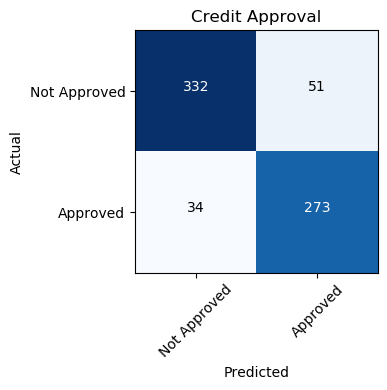

In [53]:
f = plt.figure(dpi = 100)
plot_confusion_matrix(cm, ["Not Approved", "Approved"], title='Credit Approval')
plt.show()